# Boston House Price Prediction
* Dataset: https://www.kaggle.com/vikrishnan/boston-house-prices
* Columns:
    * CRIM per capita crime rate by town
    * ZN proportion of residential land zoned for lots over 25,000 sq.ft.
    * INDUS proportion of non-retail business acres per town
    * CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    * NOX nitric oxides concentration (parts per 10 million) 
    * RM average number of rooms per dwelling 
    * AGE proportion of owner-occupied units built prior to 1940 
    * DIS weighted distances to five Boston employment centres
    * RAD index of accessibility to radial highways 
    * TAX full-value property-tax rate per 10,000 dollars 
    * PTRATIO pupil-teacher ratio by town 
    * B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
    * LSTAT \% lower status of the population

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

In [8]:
data = pd.read_csv("housing.csv", delimiter=r"\s+", names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE'], header=None)
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## Data Exploration

In [10]:
# shape of dataset
data.shape

(506, 14)

In [11]:
# check for missing values
data.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
PRICE      0
dtype: int64

In [12]:
# statiscal measures of the dataset
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Correlation

<AxesSubplot:>

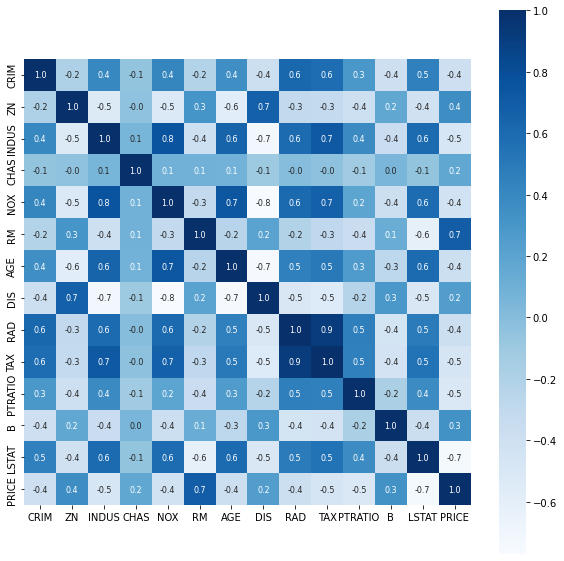

In [15]:
corr = data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')

## Build model

In [18]:
# splitting the data and the target (price)
X = data.drop(['PRICE'], axis=1)
Y = data['PRICE']
X,Y

(        CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
 0    0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
 1    0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
 2    0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
 3    0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
 4    0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   
 ..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
 501  0.06263   0.0  11.93     0  0.573  6.593  69.1  2.4786    1  273.0   
 502  0.04527   0.0  11.93     0  0.573  6.120  76.7  2.2875    1  273.0   
 503  0.06076   0.0  11.93     0  0.573  6.976  91.0  2.1675    1  273.0   
 504  0.10959   0.0  11.93     0  0.573  6.794  89.3  2.3889    1  273.0   
 505  0.04741   0.0  11.93     0  0.573  6.030  80.8  2.5050    1  273.0   
 
      PTRATIO       B  LSTAT  
 0       15.3  396.90   4.98  
 1       17.8  396.90   

In [19]:
# splitting the data into training data and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2)

## Model training

In [20]:
# loading the model
model = XGBRegressor()

In [21]:
# training the model with X_train
model.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Train Prediction

In [22]:
# prediction with training data
train_prediction = model.predict(X_train)

In [32]:
# R squared error
metrics.r2_score(Y_train, train_prediction)

0.9999948236320982

In [33]:
# Mean Absolute Error
metrics.mean_absolute_error(Y_train, train_prediction)

0.0145848437110976

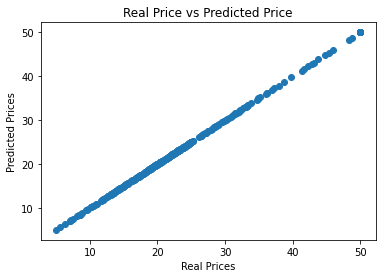

In [30]:
plt.scatter(Y_train, train_prediction)
plt.xlabel("Real Prices") 
plt.ylabel("Predicted Prices")
plt.title("Real Price vs Predicted Price")
plt.show()

### Test data

In [31]:
# prediction with test data
test_prediction = model.predict(X_test)

In [34]:
# R squared error
metrics.r2_score(Y_test, test_prediction)

0.8711660369151691

In [36]:
# Mean Absolute Error
metrics.mean_absolute_error(Y_test, test_prediction)

2.2834744154238233

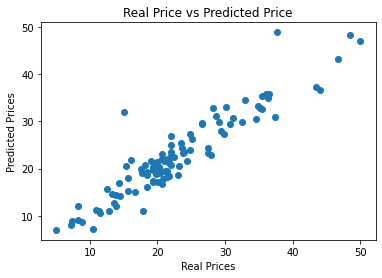

In [37]:
plt.scatter(Y_test, test_prediction)
plt.xlabel("Real Prices")
plt.ylabel("Predicted Prices")
plt.title("Real Price vs Predicted Price")
plt.show()